# Tutorial: Cycle-Consistent Spatial Transforming Autoencoders

By Shuyu Qin, Joshua C. Agar

Department of Mechanical Engineering and Mechanics
Drexel University

In [1]:
!pip install m3_learning

## Configuration

### Imports packages


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
import cv2
from skimage.filters import sobel
import tarfile

### Downloads Files

In [3]:
!wget -O cards.tar.xz https://github.com/m3-learning/m3_learning/blob/main/m3_learning/Tutorials/Cycle_Consistent_Spatial_Transformer_Autoencoder/data/cards.tar.xz?raw=true
!wget -O 11.12_unsupervised_learn_label_epoch_17957_coef_0_trainloss_0.0008.pkl https://github.com/m3-learning/Unsupervised-rotation-detection-and-label-learning/blob/main/11.12_unsupervised_learn_label_epoch_17957_coef_0_trainloss_0.0008.pkl?raw=true

'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.


### Extracts Files

In [4]:
file = tarfile.open('./cards.tar.xz') 
file.extractall('./')
file.close()

## Data Preprocessing

### Conversion

In [5]:
# Converts images to grayscale
card1 = cv2.imread("cards/card1.JPG", cv2.IMREAD_GRAYSCALE)
card2 = cv2.imread("cards/card2.JPG", cv2.IMREAD_GRAYSCALE)
card3 = cv2.imread("cards/card3.JPG", cv2.IMREAD_GRAYSCALE)
card4 = cv2.imread("cards/card4.JPG", cv2.IMREAD_GRAYSCALE)

# Normalizes the image based on the max value
card1 = torch.tensor(1 - card1 / card1.max())
card2 = torch.tensor(1 - card2 / card2.max())
card3 = torch.tensor(1 - card3 / card3.max())
card4 = torch.tensor(1 - card4 / card4.max())

# # Resizes the image
# card_small_1 = torch.tensor(F.interpolate(card1.unsqueeze(0).unsqueeze(1), size=(48,48)),dtype=torch.float)
# card_small_2 = torch.tensor(F.interpolate(card2.unsqueeze(0).unsqueeze(1), size=(48,48)),dtype=torch.float)
# card_small_3 = torch.tensor(F.interpolate(card3.unsqueeze(0).unsqueeze(1), size=(48,48)),dtype=torch.float)
# card_small_4 = torch.tensor(F.interpolate(card4.unsqueeze(0).unsqueeze(1), size=(48,48)),dtype=torch.float)

# Resizes the image
card_small_1 = F.interpolate(card1.unsqueeze(0).unsqueeze(1), size=(48,48)).clone().type(torch.float).cpu().numpy()
card_small_2 = F.interpolate(card2.unsqueeze(0).unsqueeze(1), size=(48,48)).clone().type(torch.float).cpu().numpy()
card_small_3 = F.interpolate(card3.unsqueeze(0).unsqueeze(1), size=(48,48)).clone().type(torch.float).cpu().numpy()
card_small_4 = F.interpolate(card4.unsqueeze(0).unsqueeze(1), size=(48,48)).clone().type(torch.float).cpu().numpy()

### Raw Data Visulalization

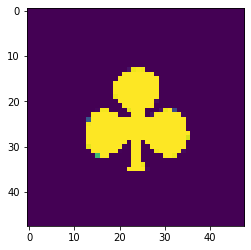

In [6]:
plt.imshow(card_small_1.squeeze())

### Edge detection

In [7]:
# Sobel edge detection
card_edge_1 = sobel(card_small_1.squeeze())
card_edge_2 = sobel(card_small_2.squeeze())
card_edge_3 = sobel(card_small_3.squeeze())
card_edge_4 = sobel(card_small_4.squeeze())

# Convert to a tensor
card_edge_1 = torch.tensor(card_edge_1,dtype=torch.float).unsqueeze(0).unsqueeze(1)
card_edge_2 = torch.tensor(card_edge_2,dtype=torch.float).unsqueeze(0).unsqueeze(1)
card_edge_3 = torch.tensor(card_edge_3,dtype=torch.float).unsqueeze(0).unsqueeze(1)
card_edge_4 = torch.tensor(card_edge_4,dtype=torch.float).unsqueeze(0).unsqueeze(1)

## Data Generation

This will generate a bunch of images that are rotated from the initial position

In [8]:
# sets the range and the number of steps to generate images
angle = torch.linspace(0, 2*np.pi, 2000)

# predefines a list
input_data_set_1 = []
input_data_set_2 = []
input_data_set_3 = []
input_data_set_4 = []

for q in angle:
    # defines the theta matrix for an affine transformation
    theta = torch.tensor([
     [torch.cos(q), torch.sin(q)  , 0],
     [-torch.sin(q), torch.cos(q), 0]
     ], dtype=torch.float)
    
    # calculates the grid for the affine transformation
    grid = F.affine_grid(theta.unsqueeze(0), card_edge_1.size()) 
    
    # applies the affine transformation to the image
    output = F.grid_sample(card_edge_1, grid)
    # adds the image to the dataset
    input_data_set_1.append(output)
    
    output = F.grid_sample(card_edge_2, grid)
    input_data_set_2.append(output)
    
    output = F.grid_sample(card_edge_3, grid)
    input_data_set_3.append(output)
    
    output = F.grid_sample(card_edge_4, grid)
    input_data_set_4.append(output)

# combines all the data together    
input_set_1 = torch.stack(input_data_set_1).squeeze(1)
input_set_2 = torch.stack(input_data_set_2).squeeze(1)
input_set_3 = torch.stack(input_data_set_3).squeeze(1)
input_set_4 = torch.stack(input_data_set_4).squeeze(1)

c:\Conda\lib\site-packages\torch\nn\functional.py:4277: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
c:\Conda\lib\site-packages\torch\nn\functional.py:4215: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


### Visualize example rotated images

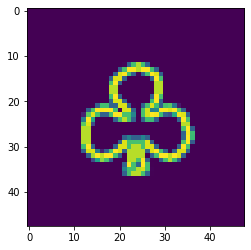

In [9]:
plt.imshow(card_edge_1.squeeze())

### Formulate a single dataset

In [10]:
input_set = torch.cat((input_set_1,input_set_2,input_set_3,input_set_4),axis=0)

### Visualize example images in training data

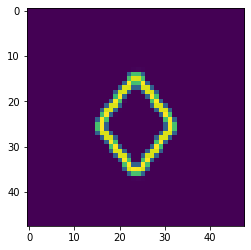

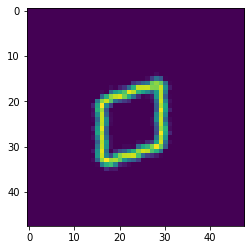

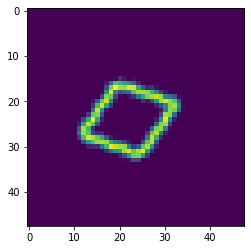

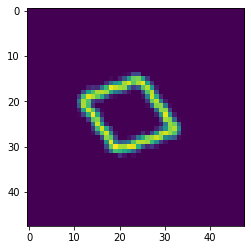

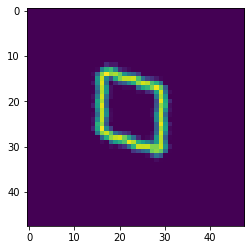

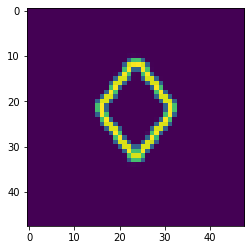

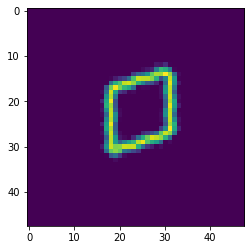

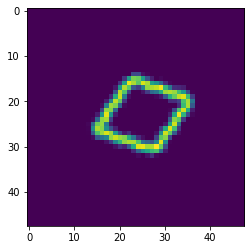

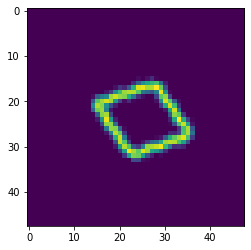

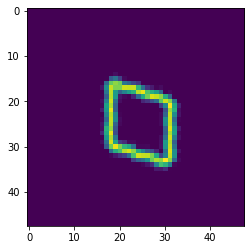

In [11]:
for i in range(2000): 
    if i%200 == 0:
        plt.figure()
        plt.imshow(input_set_4[i].squeeze())

## Builds the Neural Network

### Convolutional Block

This is a standard convolutional block with ReLu. Each block has 4 layers. There is a layer normalization, and ResNet-like message passing.

In [12]:
class conv_block(nn.Module):
    def __init__(self,t_size,n_step):
        super(conv_block,self).__init__()
        self.cov1d_1 = nn.Conv2d(t_size,t_size,3,stride=1,padding=1,padding_mode = 'zeros')
        self.cov1d_2 = nn.Conv2d(t_size,t_size,3,stride=1,padding=1,padding_mode = 'zeros')
        self.cov1d_3 = nn.Conv2d(t_size,t_size,3,stride=1,padding=1,padding_mode = 'zeros')
        self.norm_3 = nn.LayerNorm(n_step)
        self.relu_1 = nn.ReLU()
        self.relu_2 = nn.ReLU()
        self.relu_3 = nn.ReLU()
        
    def forward(self,x):
        x_input = x
        out = self.cov1d_1(x)
        out = self.relu_1(out)
        out = self.cov1d_2(out)
        out = self.relu_2(out)
        out = self.cov1d_3(out)
        out = self.norm_3(out)
        out = self.relu_3(out)
        out = out.add(x_input)
        
        return out

### Idenity Block
This is a single convolutional layer with a layer norm and ReLu activation function

In [13]:
class identity_block(nn.Module):
    def __init__(self,t_size,n_step):
        super(identity_block,self).__init__()
        self.cov1d_1 = nn.Conv2d(t_size,t_size,3,stride=1,padding=1,padding_mode = 'zeros')
        self.norm_1 = nn.LayerNorm(n_step)
        self.relu = nn.ReLU()
        
    def forward(self,x):
        x_input = x
        out = self.cov1d_1(x)
        out = self.norm_1(out)
        out = self.relu(out)
        return out

### Encoder construction

This constructs the encoder using the convolutional and identity blocks. 

In [14]:
class Encoder(nn.Module):
    def __init__(self,original_step_size,pool_list,embedding_size,conv_size):
        super(Encoder,self).__init__()
        
        # list of blocks
        blocks = []

        # defines the orignal step size
        self.input_size_0 = original_step_size[0]
        self.input_size_1 = original_step_size[1]

        # a list that has the number of pooling layers
        number_of_blocks = len(pool_list)

        # Adds an initial Conv_block, identity block and max pool
        blocks.append(conv_block(t_size=conv_size, n_step=original_step_size))
        blocks.append(identity_block(t_size=conv_size, n_step=original_step_size))
        blocks.append(nn.MaxPool2d(pool_list[0], stride=pool_list[0]))

        # adds additional layers based on the number of blocks
        for i in range(1,number_of_blocks):
            original_step_size = [original_step_size[0]//pool_list[i-1],original_step_size[1]//pool_list[i-1]]
            blocks.append(conv_block(t_size=conv_size, n_step=original_step_size))
            blocks.append(identity_block(t_size=conv_size, n_step=original_step_size))
            blocks.append(nn.MaxPool2d(pool_list[i], stride=pool_list[i])) 
            
        # defines the convolutional embedding blocks    
        self.block_layer = nn.ModuleList(blocks)


        self.layers=len(blocks)

        original_step_size = [original_step_size[0]//pool_list[-1],original_step_size[1]//pool_list[-1]]
        
        input_size = original_step_size[0]*original_step_size[1]
        
        # defines the initial layer
        self.cov2d = nn.Conv2d(1,conv_size,3,stride=1,padding=1,padding_mode = 'zeros')
        
        # defines the conv layer at the end of the conv block
        self.cov2d_1 = nn.Conv2d(conv_size,1,3,stride=1,padding=1,padding_mode = 'zeros')
        
        self.relu_1 = nn.ReLU()
        self.tanh = nn.Tanh()
 
        # Layer that takes the ouput of the conv block and reduces its dimensionsl to 20
        self.before = nn.Linear(input_size,20)

        # layer that takes the 20 parameter latent space and learns the embedding of the affine transformation
        self.dense = nn.Linear(20,embedding_size)



        
    def forward(self,x):

        out = x.view(-1,1,self.input_size_0,self.input_size_1)
        out = self.cov2d(out)
        for i in range(self.layers):
            out = self.block_layer[i](out)
        out = self.cov2d_1(out)

        # flattens the conv layers so it is 1D
        out = torch.flatten(out,start_dim=1)

        # Embedding that goes to the classification layer
        kout = self.before(out)    
      
        # Fully connected layer that helps learn the affine transformation
        out = self.dense(kout)
        out = self.tanh(out)

        theta = out.view(-1,2,3)
        
        # learns the grid of the affine tranformation
        grid = F.affine_grid(theta.to(device), x.size()).to(device)
        
        # applies the affine transformation to the image
        output = F.grid_sample(x, grid)
   
        
        return output,kout,theta

### Decoder

In [15]:
class Decoder(nn.Module):
    def __init__(self,original_step_size,up_list,embedding_size,conv_size):
        super(Decoder,self).__init__()

        # Defines the size of the input
        self.input_size_0 = original_step_size[0]
        self.input_size_1 = original_step_size[1]

        # dense layer used for the probability of beloning to each class
        self.dense = nn.Linear(4,original_step_size[0]*original_step_size[1])

        self.cov2d = nn.Conv2d(1,conv_size,3,stride=1,padding=1,padding_mode = 'zeros')
        self.cov2d_1 = nn.Conv2d(conv_size,1,3,stride=1,padding=1,padding_mode = 'zeros')
        
        # list where the blocks are saved
        blocks = []

        # number of blocks in the model
        number_of_blocks = len(up_list)

        # adds the blocks to the model
        blocks.append(conv_block(t_size=conv_size, n_step=original_step_size))
        blocks.append(identity_block(t_size=conv_size, n_step=original_step_size))
        
        for i in range(number_of_blocks):
            # adds an upsampling layer to compensate for pooling
            blocks.append(nn.Upsample(scale_factor=up_list[i], mode='bilinear', align_corners=True))
            original_step_size = [original_step_size[0]*up_list[i],original_step_size[1]*up_list[i]]
            blocks.append(conv_block(t_size=conv_size, n_step=original_step_size))
            blocks.append(identity_block(t_size=conv_size, n_step=original_step_size))
            
        self.block_layer = nn.ModuleList(blocks)
        self.layers=len(blocks)
        self.output_size_0 = original_step_size[0]
        self.output_size_1 = original_step_size[1]
        self.relu_1 = nn.ReLU()
        self.norm = nn.LayerNorm(4)

        # used to convert probability into classification
        self.softmax = nn.Softmax()
        
        # prediction layer for classification
        self.for_k = nn.Linear(20,4)

        # number of outputs for the classification layer
        self.num_k_sparse=1

    def ktop(self,x):
        # This conduct the classification based on the encoded value
        kout = self.for_k(x)
        kout = self.norm(kout)
        kout = self.softmax(kout)
        k_no = kout.clone()
        k = self.num_k_sparse
        with torch.no_grad():
            if k < kout.shape[1]:
                for raw in k_no:
                    # computes the k-top layer
                    indices = torch.topk(raw, k)[1].to(device)

                    # creates a one-hot encoded vector
                    mask = torch.ones(raw.shape, dtype=bool).to(device)
                    mask[indices] = False
                    raw[mask] = 0
                    raw[~mask] = 1
        return k_no

        
    def forward(self,x):
        # Does the classification
        k_out = self.ktop(x)

        # uses the classification to the decoder
        out = self.dense(k_out)

        # reshapes the tensor to be an image of the size of the original image
        out = out.view(-1,1,self.input_size_0,self.input_size_1)
        
        # computes the decoder
        out = self.cov2d(out)
        for i in range(self.layers):
            out = self.block_layer[i](out)
        out = self.cov2d_1(out)
        out = self.relu_1(out)

        
        return out, k_out

### Builds the autoencoder

In [16]:
class Joint(nn.Module):
  # Module that combines the encoder and the decoder

    def __init__(self,encoder,decoder):
        super(Joint,self).__init__()
        
        # encoder and decoder
        self.encoder  = encoder
        self.decoder = decoder

        
    def forward(self,x):

        # gets the result from the encoder 
        predicted,kout,theta = self.encoder(x)
    
        # Builds the theta matrix
        # We use an identity to ensure there is no translation  
        identity = torch.tensor([0,0,1],dtype= torch.float).reshape(1,1,3).repeat(x.shape[0],1,1).to(device)
        new_theta = torch.cat((theta,identity),axis=1).to(device)

        # Computes the inverse of the affine transoformation
        inver_theta = torch.linalg.inv(new_theta)[:,0:2].to(device) 

        # Calculates the grid for inverse affine
        grid = F.affine_grid(inver_theta.to(device), x.size()).to(device)
        
        # Computes the decoder
        predicted_base,k_out = self.decoder(kout)
        
        # applies the inverse affine transformation to the decoded base
        predicted_input = F.grid_sample(predicted_base, grid)
        
        return predicted,predicted_base,predicted_input,k_out,theta

### Sets optional parameters for autoencoder

In [17]:
# Size of the original image
en_original_step_size=[48,48]

# Defines the pooling layer
pool_list=[2,2,2]

# defines the size of the tensor 
de_original_step_size = [4,4]

# Defines how the upsampling should be conducted
up_list = [2,2,3]

# Sets the size of the embedding, this is the number of parameters in the affine
embedding_size=6

# Sets the number of neurons in each layer
conv_size =128

### Checks operations

In [18]:
# checks if cuda is available
print(torch.cuda.is_available())

# Assigns device to cuda
device = torch.device('cuda')

True


### Instantiates the model

In [19]:
# instantiates the encoder
encoder = Encoder(original_step_size=en_original_step_size,
                  pool_list=pool_list,
                  embedding_size=embedding_size,
                  conv_size=conv_size).to(device)

# instantiates the decoder
decoder = Decoder(original_step_size=de_original_step_size,
                  up_list=up_list,
                  embedding_size=embedding_size,
                  conv_size=conv_size).to(device)

# combines the two models                 
join = Joint(encoder,decoder).to(device)

### Instantiate the optimizer

In [20]:
optimizer = optim.Adam(join.parameters(), lr=3e-5)

### Loads pretrained weights

In [21]:
# if you would like to train this model from scratch set equal to false.
# Note this model takes many hours to train
pretrained = True

if pretrained: 
    # load the trained weights
    path_checkpoint = "./11.12_unsupervised_learn_label_epoch_17957_coef_0_trainloss_0.0008.pkl"  
    checkpoint = torch.load(path_checkpoint,map_location=torch.device('cpu'))  

    join.load_state_dict(checkpoint['net'])
    encoder.load_state_dict(checkpoint['encoder'])
    decoder.load_state_dict(checkpoint['decoder'])
    optimizer.load_state_dict(checkpoint['optimizer']) 
    start_epoch = checkpoint['epoch']


### Loss Function

In [22]:
def loss_function(join,
                  train_iterator,
                  optimizer,
                  ln_parm = 1, 
                  beta = None):

    # weight_decay = coef
    # weight_decay_1 = coef1

    # set the train mode
    join.train()

    # loss of the epoch
    train_loss = 0

    # loop for calculating loss 
    for x in tqdm(train_iterator, leave=True, total=len(train_iterator)):
     

        x = x.to(device, dtype=torch.float)

        # update the gradients to zero
        optimizer.zero_grad()

        # computes the forward pass of the model
        predicted_x,predicted_base,predicted_input,kout,theta = join(x)

        # combines the loss from the affine and inverse affine transform
        loss = F.mse_loss(predicted_base.squeeze(), predicted_x.squeeze(), reduction='mean')\
                + F.mse_loss(predicted_input.squeeze(), x.squeeze(), reduction='mean')

        # backward pass
        train_loss += loss.item()

        # computes the gradients
        loss.backward()
        
        # update the weights
        optimizer.step()

    return train_loss

## Model Training

In [23]:
def Train(join,encoder,decoder,train_iterator,optimizer,
          epochs,coef=0,coef_1=0,ln_parm=1, beta=None, epoch_ = None):
    
    # sets the number of epochs to train
    N_EPOCHS = epochs

    best_train_loss = float('inf')
    
    if epoch_==None:
        start_epoch = 0
    else:
        start_epoch = epoch_+1

    # loops around the data set for each epoch
    for epoch in range(start_epoch,N_EPOCHS):

        # computes the loss
        train = loss_function(join,train_iterator,
                              optimizer,ln_parm,beta)
        
        # updates and prints the loss
        train_loss = train
        train_loss /= len(train_iterator)
        print(f'Epoch {epoch}, Train Loss: {train_loss:.4f}')
        print('.............................')

        # If the model shows improvement after 50 epochs will save
        if best_train_loss > train_loss:
            best_train_loss = train_loss
            patience_counter = 1
            checkpoint = {
                "net": join.state_dict(),
                "encoder":encoder.state_dict(),
                "decoder":decoder.state_dict(),
                'optimizer': optimizer.state_dict(),
                "epoch": epoch,
            }
            if epoch >=50:
                torch.save(checkpoint, f'/content/drive/MyDrive/cycle_AE_model/11.12_unsupervised_learn_label_epoch:{epoch}_coef:{coef}_trainloss:{train_loss:.4f}.pkl')

### Data loader

Defines an iterator that serves as the data loader

In [24]:
train_iterator = torch.utils.data.DataLoader(input_set, batch_size = 300,shuffle = True)

### Trains the model

In [25]:
if not pretrained:
    # unsupervised learn label
    Train(join,encoder,decoder,train_iterator,optimizer,50000, epoch_=0)

## Validation

### Generates a small dataset for 

In [26]:
# generate the test data set for validation
angle = torch.linspace(0, 7*np.pi, 25)

input_data_set_1 = []
input_data_set_2 = []
input_data_set_3 = []
input_data_set_4 = []

for q in angle:
    theta = torch.tensor([
     [torch.cos(q), torch.sin(q)  , 0],
     [-torch.sin(q), torch.cos(q), 0]
     ], dtype=torch.float)
    grid = F.affine_grid(theta.unsqueeze(0), card_edge_1.size()) 
    output = F.grid_sample(card_edge_1, grid)
    input_data_set_1.append(output)
    
    output = F.grid_sample(card_edge_2, grid)
    input_data_set_2.append(output)
    
    output = F.grid_sample(card_edge_3, grid)
    input_data_set_3.append(output)
    
    output = F.grid_sample(card_edge_4, grid)
    input_data_set_4.append(output)
    
input_set_1 = torch.stack(input_data_set_1).squeeze(1)
input_set_2 = torch.stack(input_data_set_2).squeeze(1)
input_set_3 = torch.stack(input_data_set_3).squeeze(1)
input_set_4 = torch.stack(input_data_set_4).squeeze(1)
input_set_small = torch.cat((input_set_1,input_set_2,input_set_3,input_set_4),axis=0)

### Builds a validation iterator

In [27]:
train_iterator = torch.utils.data.DataLoader(input_set_small, batch_size = 100,shuffle = False)

### Random sample visualization

In [28]:
sample = next(iter(train_iterator))

### Evaluation

In [29]:
out,base,inp,kout,theta= join(sample.to(device, dtype=torch.float))

C:\Users\Joshua Agar\AppData\Local\Temp\ipykernel_17540\46853740.py:52: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  kout = self.softmax(kout)


### Visualize the results

tensor([0., 0., 1., 0.], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([0., 0., 1., 0.], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([1., 0., 0., 0.], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([0., 0., 1., 0.], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([0., 1., 0., 0.], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([0., 0., 0., 1.], device='cuda:0', grad_fn=<SelectBackward0>)


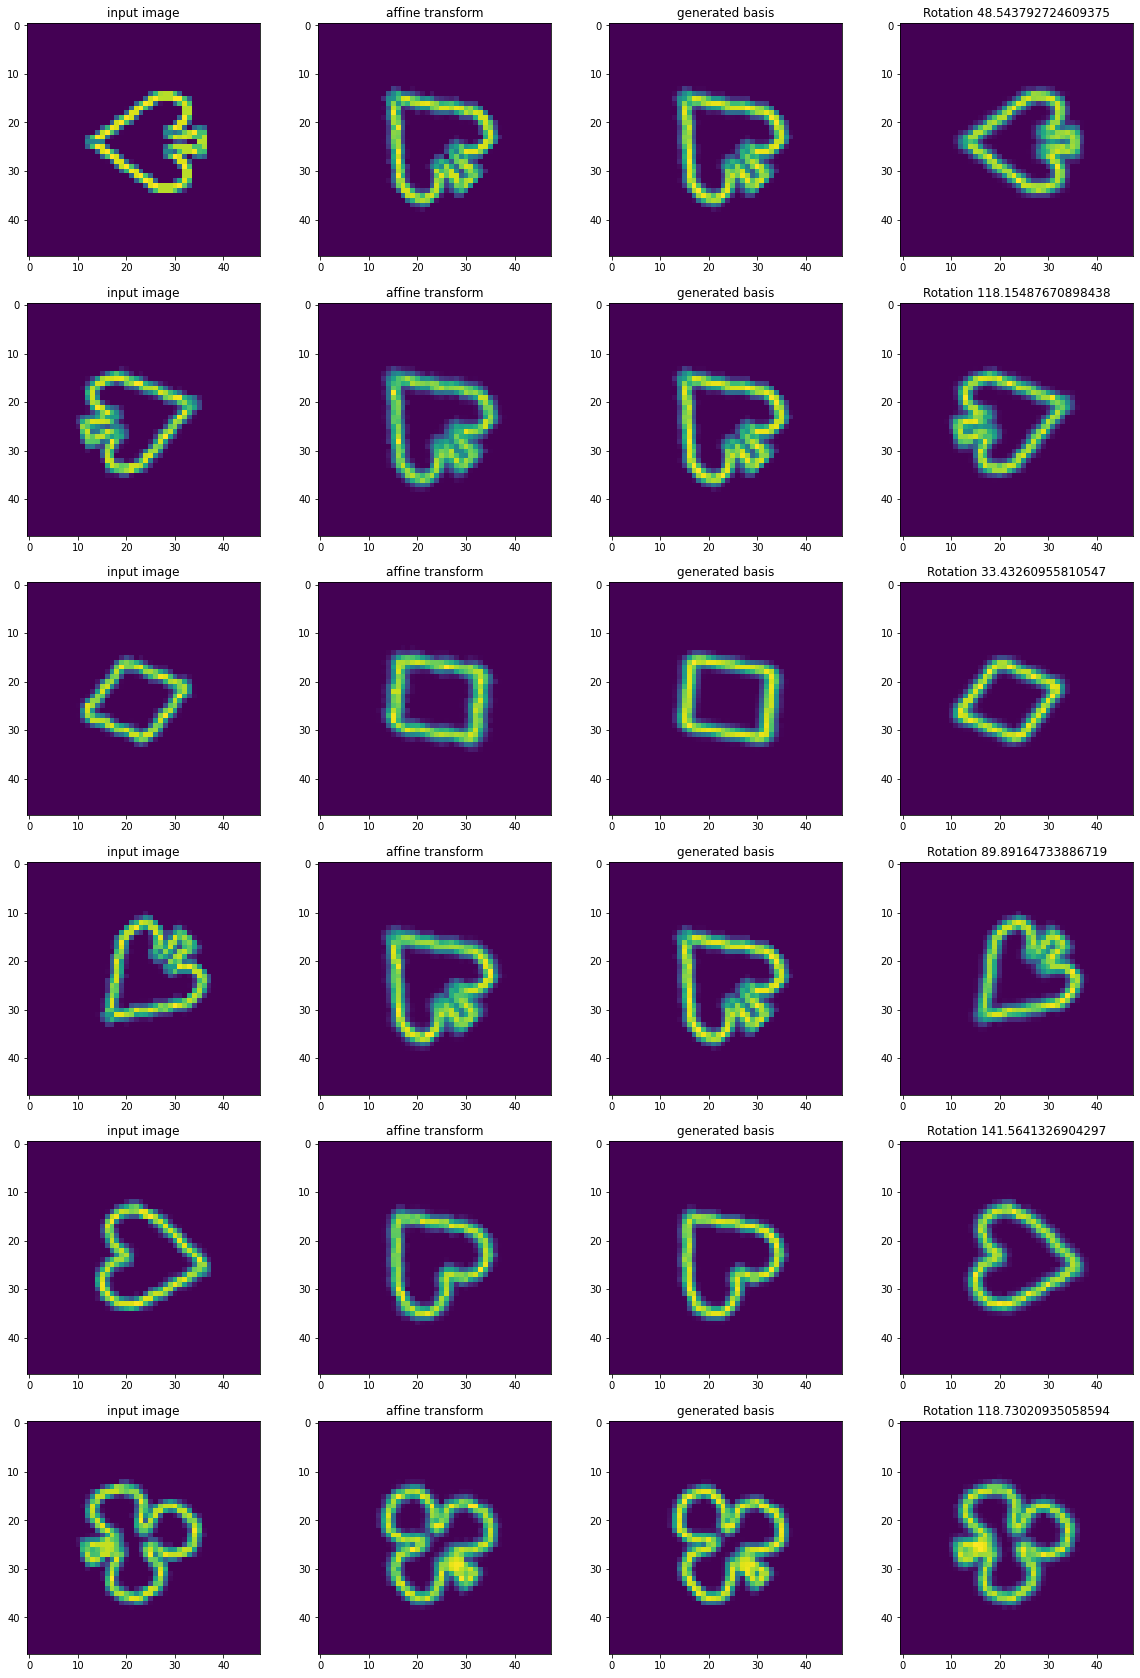

In [30]:
label_ = [card_edge_1,card_edge_2,card_edge_3,card_edge_4]

# Visualize the result
fig,ax = plt.subplots(6,4,figsize=(20,30))
for i in range(6):
    j = np.random.randint(0,100)
    ax[i][0].title.set_text('input image')
    ax[i][1].title.set_text('affine transform')
    ax[i][2].title.set_text('generated basis')
    ax[i][3].title.set_text(f'Rotation {np.degrees(np.arccos(theta[j][0,0].detach().cpu()))}')
    ax[i][0].imshow(sample[j].squeeze())
    
    ax[i][1].imshow(out[j].squeeze().detach().cpu())
    
    #ax[2].imshow((card_small.squeeze()-out[i].squeeze().detach().cpu())**2)
    #num = torch.argmax(prob[i])
    ax[i][2].imshow(base[j].squeeze().detach().cpu())
    
    ax[i][3].imshow(inp[j].squeeze().detach().cpu())
    
    #ax[3].imshow((label_[num].squeeze()-out[i].squeeze().detach().cpu())**2)
    print(kout[j])
    
